In [1]:
# Import libraries : 
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, VectorIndexer
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Initialize spark session : 

spark = SparkSession.builder \
    .appName("Random forest regressor") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

print(spark.version)

3.5.5


In [34]:
def load_data(file_path):
    return spark.read.csv(file_path, header=True, inferSchema=True)

data = load_data("data_preprocessed_V3.csv")
data.limit(5).toPandas()

,door_count,fiscal_power,mileage,price,publication_Year,publication_Month,publication_Day,Days_since_posted,Alloy_wheels,Airbags,...,model,origin,first_owner,sector,seller_city,transmission,vehicle_age,days_on_market,mileage_vehicle_age,mileage_fiscal_interaction
0,3.0,11.0,12.524526,85000.0,2025.0,2.0,11.0,78.0,1,1,...,221.0,0.0,0.0,4.0,1.0,0.0,18.0,78.0,4949982.0,3024989.0
1,5.0,8.0,10.021271,190000.0,2024.0,9.0,14.0,228.0,1,1,...,201.0,0.0,1.0,4.0,559.0,1.0,8.0,228.0,179992.0,179992.0
2,5.0,6.0,11.191342,167000.0,2025.0,2.0,11.0,78.0,1,1,...,3.0,0.0,1.0,0.0,10.0,0.0,6.0,78.0,434994.0,434994.0
3,5.0,11.0,12.128111,120000.0,2024.0,10.0,14.0,198.0,1,1,...,38.0,0.0,0.0,0.0,2.0,1.0,15.0,198.0,2774985.0,2034989.0
4,5.0,12.0,12.524526,70000.0,2025.0,2.0,11.0,78.0,1,0,...,12.0,1.0,0.0,12.0,334.0,1.0,19.0,78.0,5224981.0,3299988.0


## Prepare features:

In [35]:
# Create a dataframe of features :
features_df = data.drop('price')

# Create a vector column ---> combine multiple columns into a single vector column :
assembler = VectorAssembler( inputCols = features_df.columns, outputCol = 'features')

# Apply the assembler to the data : 
data_assembled = assembler.transform(data)

In [36]:
data_for_training = data_assembled.select('features', 'price')

## Train the model : 

In [39]:
# Split data into train and test : 
train_data, test_data = data_for_training.randomSplit([0.8, 0.2], seed=42)

# 4. Set up base model
rf = RandomForestRegressor(
    featuresCol="features", 
    labelCol="price",
    predictionCol="prediction"
)

# Define parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [5, 10]) \
    .addGrid(rf.minInstancesPerNode, [5, 10]) \
    .addGrid(rf.numTrees, [100, 200]) \
    .addGrid(rf.subsamplingRate, [0.8, 1.0]) \
    .addGrid(rf.featureSubsetStrategy, ["onethird", "sqrt"]) \
    .build()

# Set up evaluator
evaluator = RegressionEvaluator(
    labelCol="price", 
    predictionCol="prediction", 
    metricName="rmse"
)


# Create cross-validator - using 3 folds instead of 5 to save computation
cv = CrossValidator(
    estimator=rf,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3,  # Fewer folds for faster computation
    parallelism=2,  # Control parallelism based on your CPU
    seed=42
)


# Fit cross-validator to find best model
cv_model = cv.fit(train_data)

# Get best model
best_model = cv_model.bestModel


In [40]:
# Print best parameters
print(f"Best maxDepth: {best_model.getMaxDepth()}")
print(f"Best minInstancesPerNode: {best_model.getMinInstancesPerNode()}")
print(f"Best numTrees: {best_model.getNumTrees}")

Best maxDepth: 10
Best minInstancesPerNode: 5
Best numTrees: 200


# Get and save the best model 

# Evaluate the best model : 

In [45]:
# 11. Evaluate on test data
test_predictions = best_model.transform(test_data)
rmse_test = evaluator.evaluate(test_predictions)
mae_test = evaluator.evaluate(test_predictions, {evaluator.metricName: "mae"})
r2_test = evaluator.evaluate(test_predictions, {evaluator.metricName: "r2"})

print(f"Test data: {{'rmse': {rmse_test}, 'mae': {mae_test}, 'r2': {r2_test}}}")

# evaluate on train data : 
train_predictions = best_model.transform(train_data)
rmse_train = evaluator.evaluate(train_predictions)
mae_train = evaluator.evaluate(train_predictions, {evaluator.metricName: "mae"})
r2_train = evaluator.evaluate(train_predictions, {evaluator.metricName: "r2"})

print(f"Train data: {{'rmse': {rmse_train}, 'mae': {mae_train}, 'r2': {r2_train}}}")

Test data: {'rmse': 68148.92814789418, 'mae': 33172.46099196508, 'r2': 0.6963334773478782}
Train data: {'rmse': 49237.44274214596, 'mae': 27100.65602704121, 'r2': 0.8284808380969872}


In [63]:
import pandas as pd

# Evaluation metrics for test data
test_metrics = {
    'rmse': rmse_test,
    'mae': mae_test,
    'r2': r2_test
}

# Evaluation metrics for train data
train_metrics = {
    'rmse': rmse_train,
    'mae': mae_train,
    'r2': r2_train
}

# Create a DataFrame to store these metrics
metrics_df = pd.DataFrame({
    'Dataset': ['Train', 'Test'],
    'RMSE': [rmse_train, rmse_test],
    'MAE': [mae_train, mae_test],
    'R2': [r2_train, r2_test]
})

# Save the DataFrame to a CSV file
metrics_df.to_csv('random_forest_metrics.csv', index=False)

print("Metrics saved to 'random_forest_metrics.csv'")


Metrics saved to 'random_forest_metrics.csv'


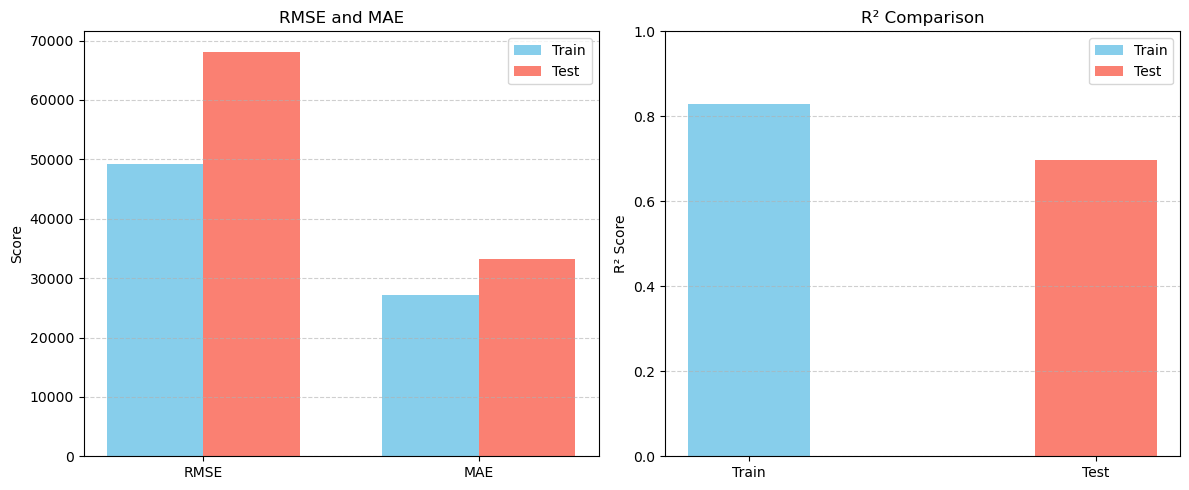

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Metric values
train_rmse, train_mae, train_r2 = rmse_train, mae_train, r2_train
test_rmse, test_mae, test_r2 = rmse_test, mae_test, r2_test

# Subplot layout
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: RMSE and MAE
metrics = ['RMSE', 'MAE']
train_scores = [train_rmse, train_mae]
test_scores = [test_rmse, test_mae]
x = np.arange(len(metrics))
bar_width = 0.35

axes[0].bar(x - bar_width/2, train_scores, bar_width, label='Train', color='skyblue')
axes[0].bar(x + bar_width/2, test_scores, bar_width, label='Test', color='salmon')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics)
axes[0].set_ylabel('Score')
axes[0].set_title('RMSE and MAE')
axes[0].legend()
axes[0].grid(axis='y', linestyle='--', alpha=0.6)

# Plot 2: R²
axes[1].bar(['Train'], [train_r2], width=0.35, label='Train', color='skyblue')
axes[1].bar(['Test'], [test_r2], width=0.35, label='Test', color='salmon')
axes[1].set_ylim(0, 1)
axes[1].set_ylabel('R² Score')
axes[1].set_title('R² Comparison')
axes[1].legend()
axes[1].grid(axis='y', linestyle='--', alpha=0.6)

# Layout
plt.tight_layout()
plt.show()

## Get features importance : 

In [49]:
from pyspark.ml.feature import VectorAssembler
import pandas as pd

# Your assembler already uses all features
feature_names = features_df.columns  # List of feature names in order

# Get the importances from the trained Random Forest model
importances = best_model.featureImportances.toArray()

# Zip and convert to a pandas dataframe
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False).reset_index(drop=True)

# Display top features
print(importance_df)

                       feature  importance
0                 transmission    0.235464
1                  vehicle_age    0.224956
2                 fiscal_power    0.103046
3                      Sunroof    0.101995
4          mileage_vehicle_age    0.073185
5                       origin    0.048713
6                        brand    0.028002
7                        model    0.027671
8                      mileage    0.019195
9              Parking_sensors    0.018546
10  mileage_fiscal_interaction    0.017035
11               Speed_limiter    0.013520
12                   fuel_type    0.012754
13                 first_owner    0.011180
14           On_board_computer    0.010348
15                Alloy_wheels    0.007424
16                 seller_city    0.007294
17                      sector    0.006715
18             publication_Day    0.005554
19              days_on_market    0.004574
20           Days_since_posted    0.004346
21                   condition    0.004322
22         

In [64]:
importance_df.to_csv("random_forest_features_importance.csv" , index= False)

C:\Users\Admin\AppData\Local\Temp\ipykernel_26544\2777387232.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=top_features, palette='viridis')


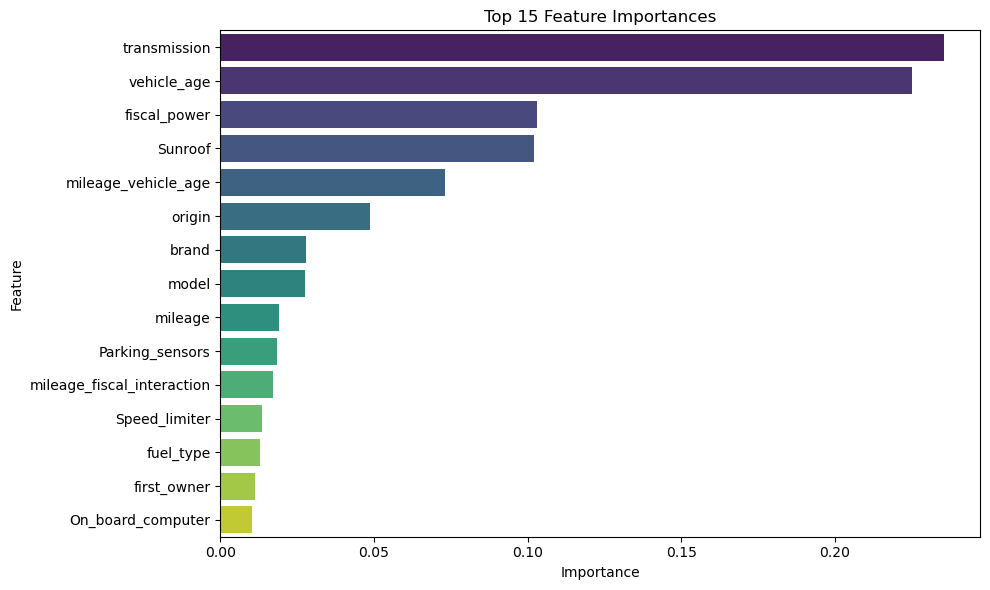

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

top_features = importance_df.sort_values(by='importance', ascending=False).head(15)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=top_features, palette='viridis')
plt.title('Top 15 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()
